In [8]:
#@title Block 1: Install Dependencies & Check GPU
import subprocess
import sys

# Install required packages
packages = [
    'transformers',
    'datasets',
    'tqdm',
    'tensorflow-hub'
]

for i, package in enumerate(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import BertTokenizer, TFBertModel
from tqdm.auto import tqdm
import json
import os
import warnings
import time
warnings.filterwarnings('ignore')

# Check GPU

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available: {len(gpus)} GPU(s) detected")
    # Enable memory growth
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Using CPU")

print(f"\nTensorFlow version: {tf.__version__}")

GPU Available: 1 GPU(s) detected

TensorFlow version: 2.19.0


In [11]:
#@title Block 2: Load Dataset

DATASET_PATH = "/content/hf_datasets/RICO-ScreenQA-Short"

dataset = load_from_disk(DATASET_PATH)
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

print("Dataset Summary:")
print(f"  Training samples:   {len(train_dataset):,}")
print(f"  Validation samples: {len(val_dataset):,}")
print(f"  Test samples:       {len(test_dataset):,}")
print(f"  Total samples:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")

print("\nFeatures:")
for feature in train_dataset.features:
    print(f"  - {feature}: {train_dataset.features[feature]}")

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Dataset Summary:
  Training samples:   68,980
  Validation samples: 8,618
  Test samples:       8,427
  Total samples:      86,025

Features:
  - screen_id: Value('string')
  - question: Value('string')
  - ground_truth: List(Value('string'))
  - file_name: Value('string')
  - image: Image(mode=None, decode=True)



Sample Data Structure:

Screen ID: 0
Question: What is the default period length?
Actual: ['five days', '5 days']
 File: images/rico/0.jpg | Size: (1080, 1920)

Screen ID: 0
Question: What is the default cycle length?
Actual: ['30', '30 days']
 File: images/rico/0.jpg | Size: (1080, 1920)

Screen ID: 0
Question: What is the start date of the last period?
Actual: ['Feb 10, 2017', 'February 10, 2017']
 File: images/rico/0.jpg | Size: (1080, 1920)

Screen ID: 0
Question: What is the name of the application?
Actual: ['<no answer>']
 File: images/rico/0.jpg | Size: (1080, 1920)

Screen ID: 1
Question: What is the upcoming cycle date?
Actual: ['February 8, 2017', 'Wednesday, February 8, 2017']
 File: images/rico/1.jpg | Size: (1080, 1920)


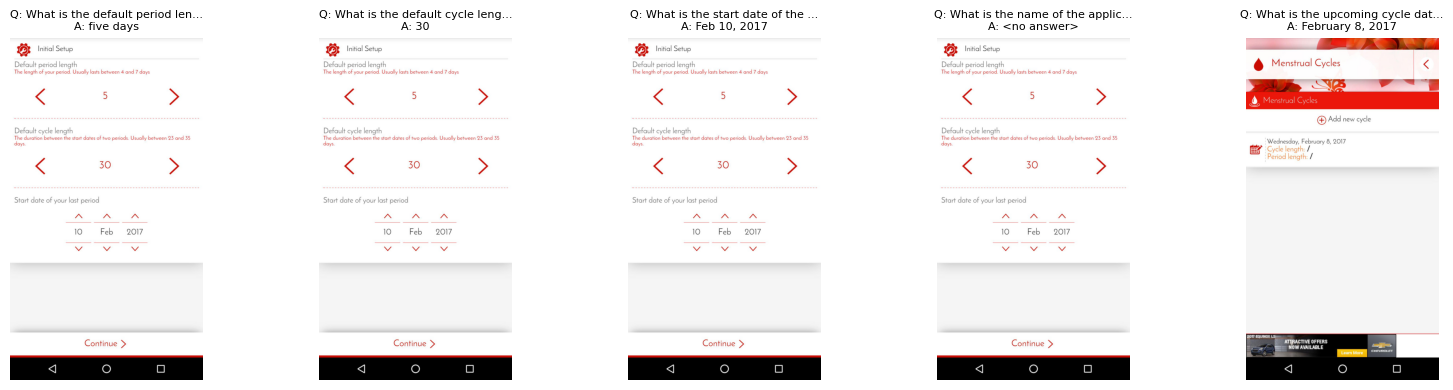

Analyzing answers: 100%|██████████| 5000/5000 [00:18<00:00, 276.63it/s]

  Unique answers (sample): 5,296
  Avg answer length: 2.55 words
  Max answer length: 85 words


In [12]:
#@title Block 3: Inspect Dataset & Show Examples

# Show sample data
print("\nSample Data Structure:")
NUM_EXAMPLES = 5
for i in range(NUM_EXAMPLES):
    sample = train_dataset[i]
    img_size = sample['image'].size if sample['image'] else 'N/A'
    print(f"\nScreen ID: {sample['screen_id']}")
    print(f"Question: {sample['question']}")
    print(f"Actual: {sample['ground_truth']}")
    print(f" File: {sample['file_name']} | Size: {img_size}")


# Visualize sample images
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
for i, ax in enumerate(axes):
    sample = train_dataset[i]
    ax.imshow(sample['image'])
    q_text = sample['question'][:30] + "..." if len(sample['question']) > 30 else sample['question']
    a_text = sample['ground_truth'][0][:20] + "..." if len(sample['ground_truth'][0]) > 20 else sample['ground_truth'][0]
    ax.set_title(f"Q: {q_text}\nA: {a_text}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.savefig('/content/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze answer distribution (sample of 5000)
sample_size = min(5000, len(train_dataset))
answer_lengths = []
unique_answers = set()

for sample in tqdm(train_dataset.select(range(sample_size)), desc="Analyzing answers"):
    for ans in sample['ground_truth']:
        answer_lengths.append(len(ans.split()))
        unique_answers.add(ans.lower().strip())

print(f"  Unique answers (sample): {len(unique_answers):,}")
print(f"  Avg answer length: {np.mean(answer_lengths):.2f} words")
print(f"  Max answer length: {max(answer_lengths)} words")

In [13]:
#@title Block 4: Configuration

class Config:
    """Central configuration for the VLM model."""

    # Image settings
    IMAGE_SIZE = 224
    PATCH_SIZE = 16
    NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2  # 196 patches

    # ResNet settings
    RESNET_FEATURE_DIM = 2048
    RESNET_FEATURE_MAP_SIZE = 7  # 7x7 feature map from ResNet50

    # ViT settings
    VIT_EMBED_DIM = 256
    VIT_NUM_HEADS = 8
    VIT_MLP_DIM = 512
    VIT_NUM_LAYERS = 4
    VIT_DROPOUT = 0.1

    # BERT settings
    BERT_MODEL_NAME = 'bert-base-uncased'
    MAX_QUESTION_LENGTH = 64
    BERT_EMBED_DIM = 768

    # Cross-attention settings
    CROSS_ATTN_HEADS = 8
    CROSS_ATTN_DIM = 256

    # Answer vocabulary settings
    MAX_VOCAB_SIZE = 5000
    MAX_ANSWER_LENGTH = 32

    # Training settings
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4
    EPOCHS = 5
    WARMUP_STEPS = 1000

    # Data settings
    TRAIN_SAMPLES = None  # None for all
    VAL_SAMPLES = None

    @classmethod
    def display(cls):
        print("Configuration Settings:\n")
        attrs = [a for a in dir(cls) if not a.startswith('_') and not callable(getattr(cls, a))]
        for attr in attrs:
            value = getattr(cls, attr)
            print(f"  {attr}: {value}")

# Display configuration
Config.display()

Configuration Settings:

  BATCH_SIZE: 64
  BERT_EMBED_DIM: 768
  BERT_MODEL_NAME: bert-base-uncased
  CROSS_ATTN_DIM: 256
  CROSS_ATTN_HEADS: 8
  EPOCHS: 5
  IMAGE_SIZE: 224
  LEARNING_RATE: 0.0001
  MAX_ANSWER_LENGTH: 32
  MAX_QUESTION_LENGTH: 64
  MAX_VOCAB_SIZE: 5000
  NUM_PATCHES: 196
  PATCH_SIZE: 16
  RESNET_FEATURE_DIM: 2048
  RESNET_FEATURE_MAP_SIZE: 7
  TRAIN_SAMPLES: None
  VAL_SAMPLES: None
  VIT_DROPOUT: 0.1
  VIT_EMBED_DIM: 256
  VIT_MLP_DIM: 512
  VIT_NUM_HEADS: 8
  VIT_NUM_LAYERS: 4
  WARMUP_STEPS: 1000


In [14]:
#@title Block 5: Preprocessing Pipeline
import subprocess
subprocess.check_call(['pip', 'install', '-q', 'tensorflow-text'])

import tensorflow_text as text
import tensorflow_hub as hub

#  Load BERT Preprocessor and Encoder from TF Hub
# Using smaller BERT for efficiency
BERT_MODEL_URL = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2"
BERT_PREPROCESS_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess = hub.load(BERT_PREPROCESS_URL)

bert_encoder_hub = hub.load(BERT_MODEL_URL)

# Getting BERT output dimension
 # For small_bert L-4_H-256_A-4
BERT_HIDDEN_SIZE = 256

print(f"  BERT hidden size: {BERT_HIDDEN_SIZE}")

# Building Answer Vocabulary
def build_answer_vocabulary(dataset, max_vocab_size=5000):
    """Build vocabulary from answer strings."""
    answer_counts = {}
    for sample in tqdm(dataset, desc="Counting answers", bar_format='{l_bar}{bar:30}{r_bar}'):
        for answer in sample['ground_truth']:
            answer_lower = answer.lower().strip()
            answer_counts[answer_lower] = answer_counts.get(answer_lower, 0) + 1

    # Sort by frequency and take top answers
    sorted_answers = sorted(answer_counts.items(), key=lambda x: -x[1])

    # Create vocabulary with special tokens
    vocab = {'<pad>': 0, '<unk>': 1, '<no answer>': 2}
    for answer, count in sorted_answers[:max_vocab_size - 3]:
        vocab[answer] = len(vocab)

    # Create reverse mapping
    inv_vocab = {v: k for k, v in vocab.items()}

    return vocab, inv_vocab

answer_vocab, inv_answer_vocab = build_answer_vocabulary(train_dataset, Config.MAX_VOCAB_SIZE)
NUM_ANSWERS = len(answer_vocab)
print(f"Answer vocabulary size: {NUM_ANSWERS:,}")
print(f"Sample answers: {list(answer_vocab.keys())[3:8]}")


# Image Preprocessing
def preprocess_image(image):
    """Preprocess PIL image to tensor."""
    # Convert to numpy array
    img_array = np.array(image.convert('RGB'))

    # Resize to target size
    img_tensor = tf.image.resize(img_array, [Config.IMAGE_SIZE, Config.IMAGE_SIZE])

    # Normalize using ImageNet statistics (for pretrained ResNet)
    img_tensor = tf.keras.applications.resnet50.preprocess_input(img_tensor)

    return img_tensor

print(f"Output shape: ({Config.IMAGE_SIZE}, {Config.IMAGE_SIZE}, 3)")

# Question Preprocessing (Using TF Hub BERT)
def preprocess_question(question):
    """Tokenize question using TF Hub BERT preprocessor."""
    # BERT preprocessor expects a tensor
    text_input = tf.constant([question])
    tokenized = bert_preprocess(text_input)

    # Extract tokens - return as numpy for the generator
    input_word_ids = tokenized['input_word_ids'].numpy()[0]
    input_mask = tokenized['input_mask'].numpy()[0]
    input_type_ids = tokenized['input_type_ids'].numpy()[0]

    # Pad or truncate to fixed length
    max_len = Config.MAX_QUESTION_LENGTH

    if len(input_word_ids) > max_len:
        input_word_ids = input_word_ids[:max_len]
        input_mask = input_mask[:max_len]
        input_type_ids = input_type_ids[:max_len]
    else:
        pad_len = max_len - len(input_word_ids)
        input_word_ids = np.pad(input_word_ids, (0, pad_len), constant_values=0)
        input_mask = np.pad(input_mask, (0, pad_len), constant_values=0)
        input_type_ids = np.pad(input_type_ids, (0, pad_len), constant_values=0)

    return input_word_ids, input_mask, input_type_ids

print(f"Max sequence length: {Config.MAX_QUESTION_LENGTH}")

# Answer Encoding
def encode_answer(ground_truth_list):
    """Encode answer to vocabulary index (use first valid answer)."""
    for answer in ground_truth_list:
        answer_lower = answer.lower().strip()
        if answer_lower in answer_vocab:
            return answer_vocab[answer_lower]
    return answer_vocab['<unk>']

def decode_answer(index):
    """Decode vocabulary index to answer string."""
    return inv_answer_vocab.get(index, '<unk>')

# Create TensorFlow Dataset
def create_tf_dataset(hf_dataset, batch_size, shuffle=True, num_samples=None):
    """Convert HuggingFace dataset to TensorFlow dataset."""
    if num_samples:
        hf_dataset = hf_dataset.select(range(min(num_samples, len(hf_dataset))))

    def generator():
        for sample in hf_dataset:
            # Process image
            image = preprocess_image(sample['image'])

            # Process question
            input_word_ids, input_mask, input_type_ids = preprocess_question(sample['question'])

            # Process answer
            answer_idx = encode_answer(sample['ground_truth'])

            yield {
                'image': image,
                'input_word_ids': input_word_ids,
                'input_mask': input_mask,
                'input_type_ids': input_type_ids
            }, answer_idx

    # Create dataset from generator
    output_signature = (
        {
            'image': tf.TensorSpec(shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), dtype=tf.float32),
            'input_word_ids': tf.TensorSpec(shape=(Config.MAX_QUESTION_LENGTH,), dtype=tf.int32),
            'input_mask': tf.TensorSpec(shape=(Config.MAX_QUESTION_LENGTH,), dtype=tf.int32),
            'input_type_ids': tf.TensorSpec(shape=(Config.MAX_QUESTION_LENGTH,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets
#Creating training dataset
train_tf = create_tf_dataset(
    train_dataset,
    Config.BATCH_SIZE,
    shuffle=True,
    num_samples=Config.TRAIN_SAMPLES
)

#Creating validation dataset
val_tf = create_tf_dataset(
    val_dataset,
    Config.BATCH_SIZE,
    shuffle=False,
    num_samples=Config.VAL_SAMPLES
)

# Verify dataset
print("\nVerifying dataset pipeline:")
for batch in train_tf.take(1):
    inputs, labels = batch
    print(f"Image batch shape: {inputs['image'].shape}")
    print(f"Input word IDs shape: {inputs['input_word_ids'].shape}")
    print(f"Input mask shape: {inputs['input_mask'].shape}")
    print(f"Input type IDs shape: {inputs['input_type_ids'].shape}")
    print(f"Labels shape: {labels.shape}")

  BERT hidden size: 256


Counting answers: 100%|██████████████████████████████| 68980/68980 [04:31<00:00, 254.41it/s]


Answer vocabulary size: 4,999
Sample answers: ['enabled', 'on', '1', 'off', 'disabled']
Output shape: (224, 224, 3)
Max sequence length: 64

Verifying dataset pipeline:
Image batch shape: (64, 224, 224, 3)
Input word IDs shape: (64, 64)
Input mask shape: (64, 64)
Input type IDs shape: (64, 64)
Labels shape: (64,)


In [15]:
#@title Block 6: Model Construction
# Patch Embedding Layer (for ViT)
class PatchEmbedding(tf.keras.layers.Layer):
    """Convert feature maps to patch embeddings with positional encoding."""
    def __init__(self, embed_dim, num_patches, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(embed_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches + 1,  # +1 for CLS token
            output_dim=embed_dim
        )
        self.cls_token = None

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, self.embed_dim),
            initializer="random_normal",
            trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        batch_size = tf.shape(x)[0]

        # Project patches
        x = self.projection(x)  # (batch, num_patches, embed_dim)

        # Adding CLS token
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embed_dim])
        x = tf.concat([cls_tokens, x], axis=1)  # (batch, num_patches+1, embed_dim)

        # Add positional embeddings
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        x = x + self.position_embedding(positions)

        return x

# Transformer Encoder Block
class TransformerEncoder(tf.keras.layers.Layer):
    """Single transformer encoder block."""
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout
        )
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation='gelu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dropout(dropout)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False):
        # Self-attention with residual
        attn_output = self.attention(x, x, training=training)
        x = self.layernorm1(x + self.dropout(attn_output, training=training))

        # MLP with residual
        mlp_output = self.mlp(x, training=training)
        x = self.layernorm2(x + mlp_output)

        return x

# Cross-Attention Layer
class CrossAttention(tf.keras.layers.Layer):
    """Cross-attention between visual and text features."""
    def __init__(self, embed_dim, num_heads, dropout=0.1, **kwargs):
        super().__init__(**kwargs)

        self.cross_attn = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(embed_dim * 4, activation='gelu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dropout(dropout)
        ])

    def call(self, query, key_value, training=False):
        # Cross-attention: query attends to key_value
        attn_output = self.cross_attn(query, key_value, training=training)
        x = self.layernorm1(query + attn_output)

        # MLP
        mlp_output = self.mlp(x, training=training)
        x = self.layernorm2(x + mlp_output)

        return x

# Visual Encoder (ResNet50 + ViT)
class VisualEncoder(tf.keras.layers.Layer):
    """ResNet50 backbone + ViT layers for visual feature extraction."""
    def __init__(self, embed_dim, num_heads, mlp_dim, num_layers, dropout=0.1, **kwargs):
        super().__init__(**kwargs)

        # ResNet50 backbone (pretrained, without top)
        self.resnet = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3),
            pooling=None
        )
        # Freeze early layers, fine-tune later layers
        for layer in self.resnet.layers[:-20]:
            layer.trainable = False

        # Number of patches from ResNet feature map (7x7 = 49)
        self.num_patches = Config.RESNET_FEATURE_MAP_SIZE ** 2

        # Patch embedding (project ResNet features to ViT dimension)
        self.patch_embed = PatchEmbedding(embed_dim, self.num_patches)

        # ViT transformer layers
        self.transformer_blocks = [
            TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]

        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, images, training=False):
        # Extract features with ResNet50
        x = self.resnet(images, training=training)  # (batch, 7, 7, 2048)

        # Flatten spatial dimensions to patches
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, [batch_size, -1, Config.RESNET_FEATURE_DIM])  # (batch, 49, 2048)

        # Apply patch embedding with positional encoding
        x = self.patch_embed(x)  # (batch, 50, embed_dim) with CLS token

        # Apply ViT transformer layers
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)

        x = self.layernorm(x)

        return x  # (batch, 50, embed_dim)

# Text Encoder (TF Hub BERT)
class TextEncoder(tf.keras.layers.Layer):
    """BERT-based text encoder using TensorFlow Hub."""
    def __init__(self, output_dim, bert_model_url, **kwargs):
        super().__init__(**kwargs)

        # Load BERT from TF Hub as a Keras layer
        self.bert = hub.KerasLayer(bert_model_url, trainable=False)

        # Projection layer to match cross-attention dimension
        self.projection = tf.keras.layers.Dense(output_dim)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, input_word_ids, input_mask, input_type_ids, training=False):
        # Prepare inputs for BERT
        bert_inputs = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        }

        # Get BERT outputs
        bert_outputs = self.bert(bert_inputs)

        # Use sequence output (all tokens)
        sequence_output = bert_outputs['sequence_output']  # (batch, seq_len, hidden_size)

        # Project to target dimension
        x = self.projection(sequence_output)
        x = self.layernorm(x)

        return x  # (batch, seq_len, output_dim)

# Complete VLM Model
class VisionLanguageModel(tf.keras.Model):
    """Complete Vision-Language Model for UI Screenshot QA."""
    def __init__(self, num_answers, bert_model_url, **kwargs):
        super().__init__(**kwargs)

        # Visual encoder
        self.visual_encoder = VisualEncoder(
            embed_dim=Config.VIT_EMBED_DIM,
            num_heads=Config.VIT_NUM_HEADS,
            mlp_dim=Config.VIT_MLP_DIM,
            num_layers=Config.VIT_NUM_LAYERS,
            dropout=Config.VIT_DROPOUT
        )

        # Text encoder
        self.text_encoder = TextEncoder(
            output_dim=Config.CROSS_ATTN_DIM,
            bert_model_url=bert_model_url
        )

        # Cross-attention (text queries visual)
        self.cross_attention = CrossAttention(
            embed_dim=Config.CROSS_ATTN_DIM,
            num_heads=Config.CROSS_ATTN_HEADS,
            dropout=0.1
        )

        # Fusion and classification
        self.fusion = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='gelu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256, activation='gelu'),
            tf.keras.layers.Dropout(0.1),
        ])

        self.classifier = tf.keras.layers.Dense(num_answers)

    def call(self, inputs, training=False):
        images = inputs['image']
        input_word_ids = inputs['input_word_ids']
        input_mask = inputs['input_mask']
        input_type_ids = inputs['input_type_ids']

        # Encode visual features
        visual_features = self.visual_encoder(images, training=training)
        # (batch, 50, 256)

        # Encode text features
        text_features = self.text_encoder(
            input_word_ids, input_mask, input_type_ids, training=training
        )
        # (batch, seq_len, 256)

        # Cross-attention: text attends to visual
        fused_features = self.cross_attention(
            query=text_features,
            key_value=visual_features,
            training=training
        )  # (batch, seq_len, 256)

        # Pool text features (use CLS token position)
        cls_features = fused_features[:, 0, :]  # (batch, 256)

        # Also pool visual features
        visual_cls = visual_features[:, 0, :]  # (batch, 256)

        # Combine both
        combined = tf.concat([cls_features, visual_cls], axis=-1)  # (batch, 512)

        # Final classification
        x = self.fusion(combined, training=training)
        logits = self.classifier(x)

        return logits

# Build model
model = VisionLanguageModel(
    num_answers=NUM_ANSWERS,
    bert_model_url=BERT_MODEL_URL
)

# Build by calling with sample input
sample_input = {
    'image': tf.zeros((1, Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3)),
    'input_word_ids': tf.zeros((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_mask': tf.ones((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32),
    'input_type_ids': tf.zeros((1, Config.MAX_QUESTION_LENGTH), dtype=tf.int32)
}
_ = model(sample_input, training=False)

print(f"Number of answer classes: {NUM_ANSWERS:,}")

Number of answer classes: 4,999


Optimizer: AdamW with warmup cosine decay
Base learning rate: 0.0001
Warmup steps: 1000
Total steps: 5,385
 Metrics: Loss (Mean), Accuracy (SparseCategoricalAccuracy)

Epoch 1/5


Training:   0%|                    | 0/1077 [00:00<?, ?it/s]

Validation: |                    | 0/? [00:00<?, ?it/s]


  Train Loss: 5.3272 | Train Acc: 0.3622
  Val Loss:   4.2805 | Val Acc:   0.4138
New best validation accuracy: 0.4138

Epoch 2/5


Training:   0%|                    | 0/1077 [00:00<?, ?it/s]

Validation: |                    | 0/? [00:00<?, ?it/s]


  Train Loss: 4.2266 | Train Acc: 0.4044
  Val Loss:   4.0462 | Val Acc:   0.4249
New best validation accuracy: 0.4249

Epoch 3/5


Training:   0%|                    | 0/1077 [00:00<?, ?it/s]

Validation: |                    | 0/? [00:00<?, ?it/s]


  Train Loss: 3.8779 | Train Acc: 0.4190
  Val Loss:   3.9258 | Val Acc:   0.4288
New best validation accuracy: 0.4288

Epoch 4/5


Training:   0%|                    | 0/1077 [00:00<?, ?it/s]

Validation: |                    | 0/? [00:00<?, ?it/s]


  Train Loss: 3.6469 | Train Acc: 0.4319
  Val Loss:   3.8850 | Val Acc:   0.4307
New best validation accuracy: 0.4307

Epoch 5/5


Training:   0%|                    | 0/1077 [00:00<?, ?it/s]

Validation: |                    | 0/? [00:00<?, ?it/s]


  Train Loss: 3.5572 | Train Acc: 0.4414
  Val Loss:   3.8307 | Val Acc:   0.4286

Training Complete
Best Validation Accuracy: 0.4307


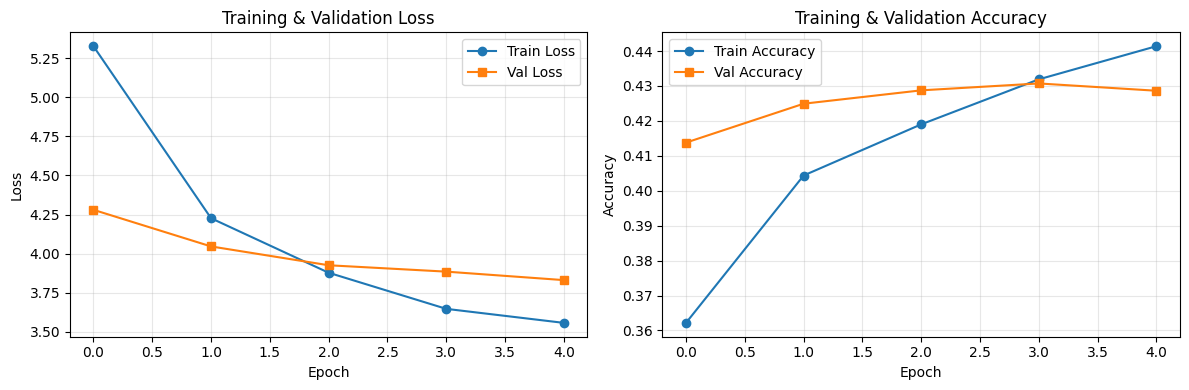

 Training history saved to /content/training_history.png


In [26]:
#@title Block 7: Training Setup & Training Loop

# Optimizer & Loss
# Learning rate schedule with warmup
class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_steps, total_steps):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)

        # Warmup phase
        warmup_lr = self.base_lr * (step / warmup_steps)

        # Cosine decay phase
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        cosine_lr = self.base_lr * 0.5 * (1.0 + tf.cos(np.pi * progress))

        return tf.where(step < warmup_steps, warmup_lr, cosine_lr)

# Calculate total steps
steps_per_epoch = len(train_dataset) // Config.BATCH_SIZE
total_steps = steps_per_epoch * Config.EPOCHS

lr_schedule = WarmupCosineDecay(
    base_lr=Config.LEARNING_RATE,
    warmup_steps=Config.WARMUP_STEPS,
    total_steps=total_steps
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=0.01
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

print(f"Optimizer: AdamW with warmup cosine decay")
print(f"Base learning rate: {Config.LEARNING_RATE}")
print(f"Warmup steps: {Config.WARMUP_STEPS}")
print(f"Total steps: {total_steps:,}")

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

print(" Metrics: Loss (Mean), Accuracy (SparseCategoricalAccuracy)")

# Training Step
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs, training=True)
        loss = loss_fn(labels, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
    # Gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_accuracy.update_state(labels, logits)

    return loss

@tf.function
def val_step(inputs, labels):
    logits = model(inputs, training=False)
    loss = loss_fn(labels, logits)

    val_loss.update_state(loss)
    val_accuracy.update_state(labels, logits)

    return loss

# Training Loop
# History for plotting
history = {
    'train_loss': [], 'train_accuracy': [],
    'val_loss': [], 'val_accuracy': []
}

best_val_accuracy = 0.0
patience_counter = 0
patience = 3

for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch + 1}/{Config.EPOCHS}")

    # Reset metrics
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

    # Training
    train_pbar = tqdm(train_tf, desc="Training",
                      bar_format='{l_bar}{bar:20}{r_bar}',
                      total=steps_per_epoch)

    for batch_idx, (inputs, labels) in enumerate(train_pbar):
        loss = train_step(inputs, labels)
        train_pbar.set_postfix({
            'loss': f'{train_loss.result():.4f}',
            'acc': f'{train_accuracy.result():.4f}'
        })

        # Limiting batches for faster testing
        if Config.TRAIN_SAMPLES and batch_idx >= Config.TRAIN_SAMPLES // Config.BATCH_SIZE:
            break

    # Validation
    val_pbar = tqdm(val_tf, desc="Validation",
                    bar_format='{l_bar}{bar:20}{r_bar}')

    for batch_idx, (inputs, labels) in enumerate(val_pbar):
        val_step(inputs, labels)
        val_pbar.set_postfix({
            'loss': f'{val_loss.result():.4f}',
            'acc': f'{val_accuracy.result():.4f}'
        })

        if Config.VAL_SAMPLES and batch_idx >= Config.VAL_SAMPLES // Config.BATCH_SIZE:
            break

    # Record history
    history['train_loss'].append(float(train_loss.result()))
    history['train_accuracy'].append(float(train_accuracy.result()))
    history['val_loss'].append(float(val_loss.result()))
    history['val_accuracy'].append(float(val_accuracy.result()))

    # Print epoch summary
    print(f"\n  Train Loss: {train_loss.result():.4f} | Train Acc: {train_accuracy.result():.4f}")
    print(f"  Val Loss:   {val_loss.result():.4f} | Val Acc:   {val_accuracy.result():.4f}")

    # Early stopping check
    current_val_acc = float(val_accuracy.result())
    if current_val_acc > best_val_accuracy:
        best_val_accuracy = current_val_acc
        patience_counter = 0
        print(f"New best validation accuracy: {best_val_accuracy:.4f}")
        # Save best model weights
        model.save_weights('/content/best_model_weights.weights.h5')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n Early stopping triggered after {epoch + 1} epochs")
            break

print("\nTraining Complete")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_accuracy'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Training history saved to /content/training_history.png")

In [29]:
#@title Block 8: Model Summary & Shape Checks

#Model Summary
#model.summary()

# Layer-by-Layer Shape Analysis
# Create sample inputs for shape tracing (using correct input format)
sample_image = tf.random.normal((2, Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3))
sample_input_word_ids = tf.zeros((2, Config.MAX_QUESTION_LENGTH), dtype=tf.int32)
sample_input_mask = tf.ones((2, Config.MAX_QUESTION_LENGTH), dtype=tf.int32)
sample_input_type_ids = tf.zeros((2, Config.MAX_QUESTION_LENGTH), dtype=tf.int32)

print("\nInput Shapes:")
print(f"  Image:           {sample_image.shape}")
print(f"  Input Word IDs:  {sample_input_word_ids.shape}")
print(f"  Input Mask:      {sample_input_mask.shape}")
print(f"  Input Type IDs:  {sample_input_type_ids.shape}")

print("\nVisual Encoder Pipeline:")
# ResNet feature extraction
resnet_features = model.visual_encoder.resnet(sample_image, training=False)
print(f"1. ResNet50 output:     {resnet_features.shape}")
print(f" (batch, height, width, channels)")

# Reshape to patches
batch_size = tf.shape(resnet_features)[0]
patches = tf.reshape(resnet_features, [batch_size, -1, Config.RESNET_FEATURE_DIM])
print(f"2. Flattened patches:   {patches.shape}")
print(f" (batch, num_patches, feature_dim)")

# After patch embedding with CLS
visual_embedded = model.visual_encoder.patch_embed(patches)
print(f"3. Patch embeddings:    {visual_embedded.shape}")
print(f"(batch, num_patches+1, embed_dim)")

# Full visual encoder output
visual_features = model.visual_encoder(sample_image, training=False)
print(f"4. Final visual output: {visual_features.shape}")

print("\nText Encoder Pipeline:")
# Text encoder with all 3 required inputs
text_features = model.text_encoder(
    sample_input_word_ids,
    sample_input_mask,
    sample_input_type_ids,
    training=False
)
print(f"1. BERT + projection:   {text_features.shape}")
print(f"(batch, seq_len, embed_dim)")

print("\nCross-Attention & Fusion:")
fused = model.cross_attention(text_features, visual_features, training=False)
print(f"1. Cross-attention:     {fused.shape}")
print(f"(batch, seq_len, embed_dim)")

cls_text = fused[:, 0, :]
cls_visual = visual_features[:, 0, :]
print(f"2. Text CLS:            {cls_text.shape}")
print(f"3. Visual CLS:          {cls_visual.shape}")

combined = tf.concat([cls_text, cls_visual], axis=-1)
print(f"4. Combined:            {combined.shape}")

# Full forward pass
sample_inputs = {
    'image': sample_image,
    'input_word_ids': sample_input_word_ids,
    'input_mask': sample_input_mask,
    'input_type_ids': sample_input_type_ids
}
logits = model(sample_inputs, training=False)
print(f"\nFinal Output:")
print(f"Logits:                 {logits.shape}")
print(f"(batch, num_answers={NUM_ANSWERS})")

# Component Parameter Breakdown
def count_layer_params(layer):
    return sum([tf.reduce_prod(v.shape).numpy() for v in layer.trainable_variables])

components = {
    'Visual Encoder (ResNet50 + ViT)': model.visual_encoder,
    'Text Encoder (BERT)': model.text_encoder,
    'Cross-Attention': model.cross_attention,
    'Fusion Network': model.fusion,
    'Classifier': model.classifier
}

for name, component in components.items():
    params = count_layer_params(component)
    print(f"{name}: {params:,} params")


Input Shapes:
  Image:           (2, 224, 224, 3)
  Input Word IDs:  (2, 64)
  Input Mask:      (2, 64)
  Input Type IDs:  (2, 64)

Visual Encoder Pipeline:
1. ResNet50 output:     (2, 7, 7, 2048)
 (batch, height, width, channels)
2. Flattened patches:   (2, 49, 2048)
 (batch, num_patches, feature_dim)
3. Patch embeddings:    (2, 50, 256)
(batch, num_patches+1, embed_dim)
4. Final visual output: (2, 50, 256)

Text Encoder Pipeline:
1. BERT + projection:   (2, 64, 256)
(batch, seq_len, embed_dim)

Cross-Attention & Fusion:
1. Cross-attention:     (2, 64, 256)
(batch, seq_len, embed_dim)
2. Text CLS:            (2, 256)
3. Visual CLS:          (2, 256)
4. Combined:            (2, 512)

Final Output:
Logits:                 (2, 4999)
(batch, num_answers=4999)
Visual Encoder (ResNet50 + ViT): 11,577,856 params
Text Encoder (BERT): 0 params
Cross-Attention: 0 params
Fusion Network: 393,984 params
Classifier: 1,284,743 params


Loading best model weights...
Best weights loaded

[9.1] Defining Enhanced Inference Functions...
------------------------------------------------------------


Running inference: 100%|████████████████████████████████████████| 100/100 [00:14<00:00,  7.04it/s]


Completed inference on 100 examples

 Overall Accuracy:
Top-1 Accuracy:   9.00% (9/100) │
Top-3 Accuracy:  15.00% (15/100) │
Top-5 Accuracy:  18.00% (18/100) │

Confidence Analysis:
Correct predictions:   avg conf = 49.2%
Incorrect predictions: avg conf = 49.5%


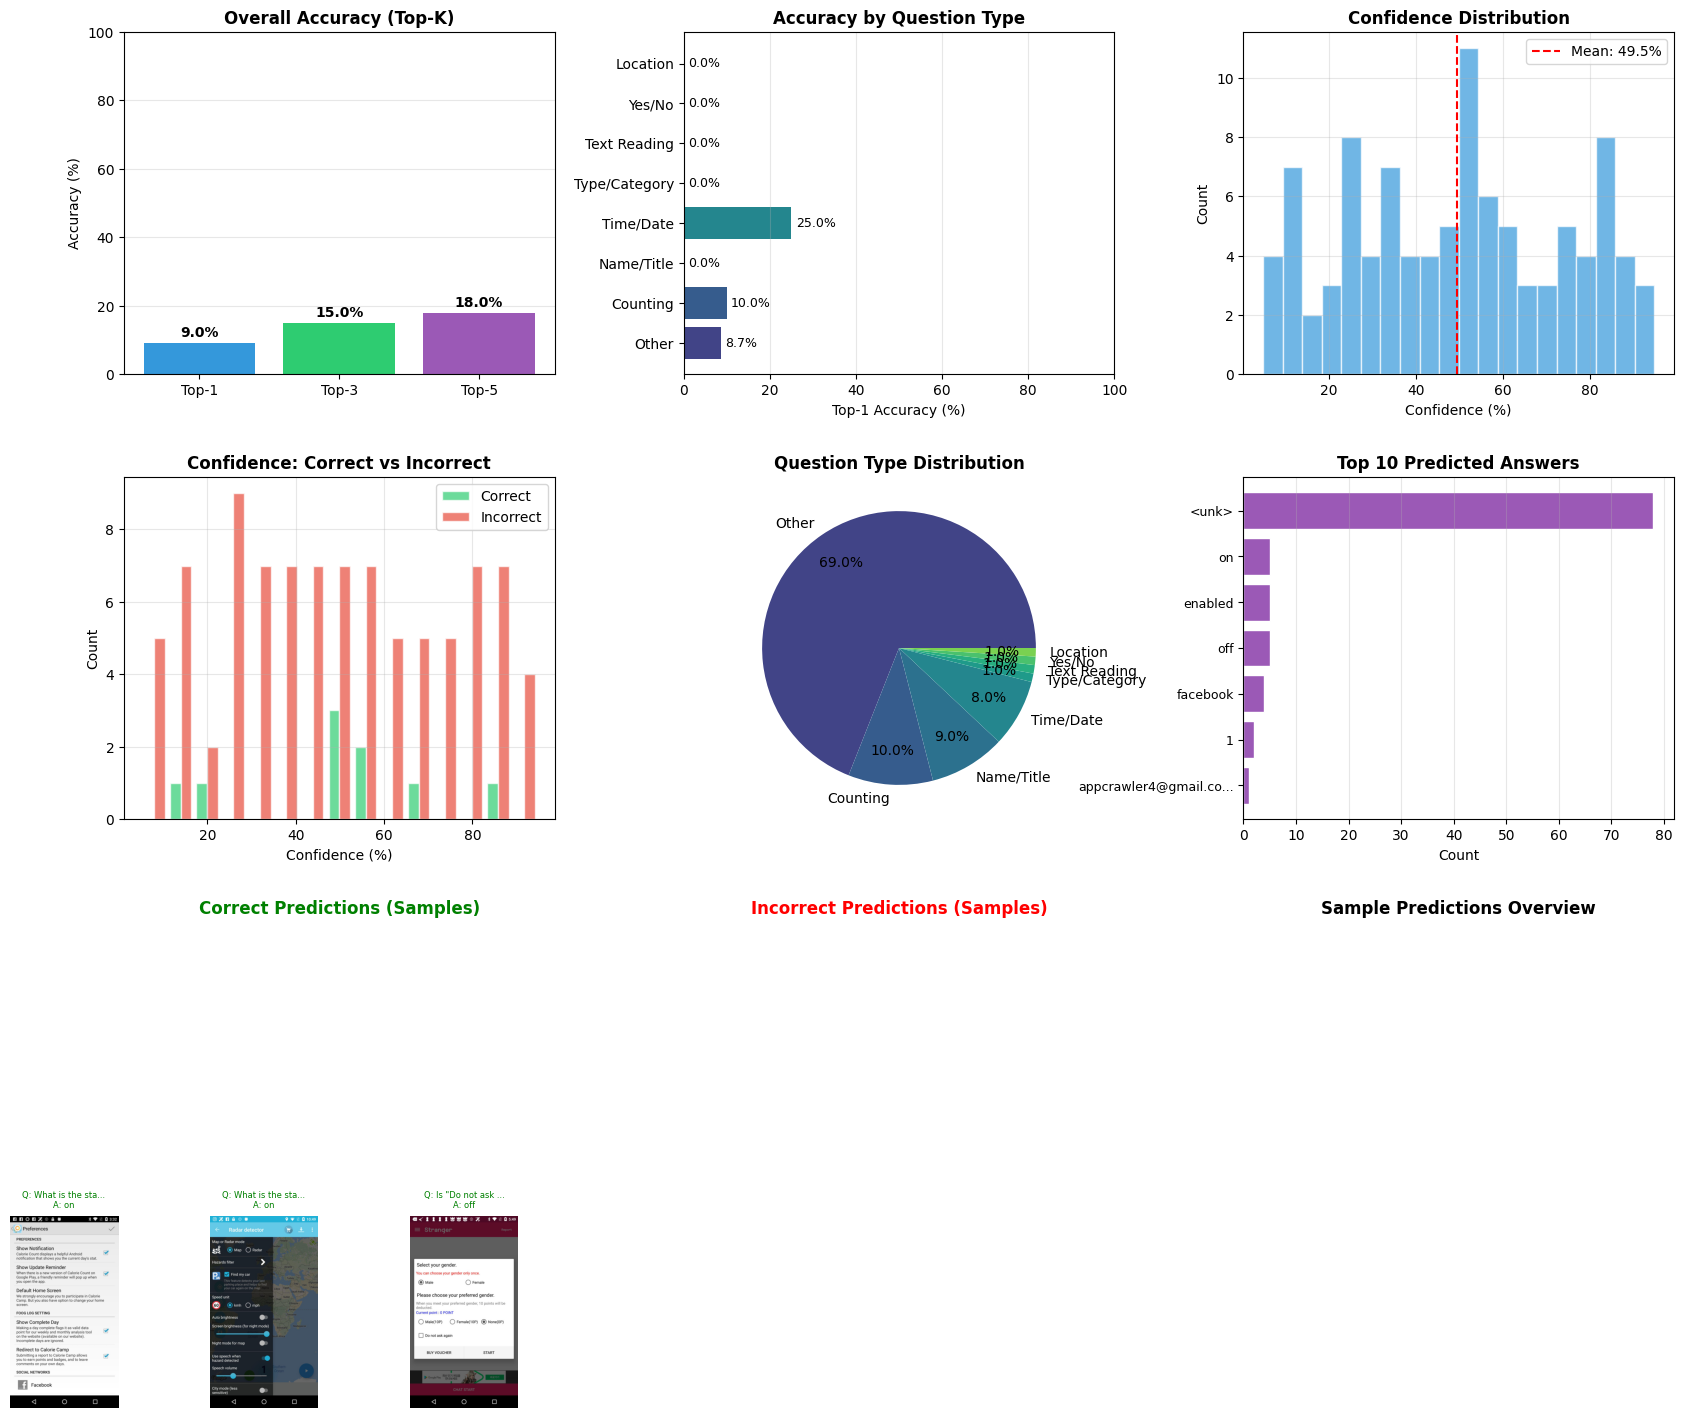

Saved: /content/comprehensive_analysis.png


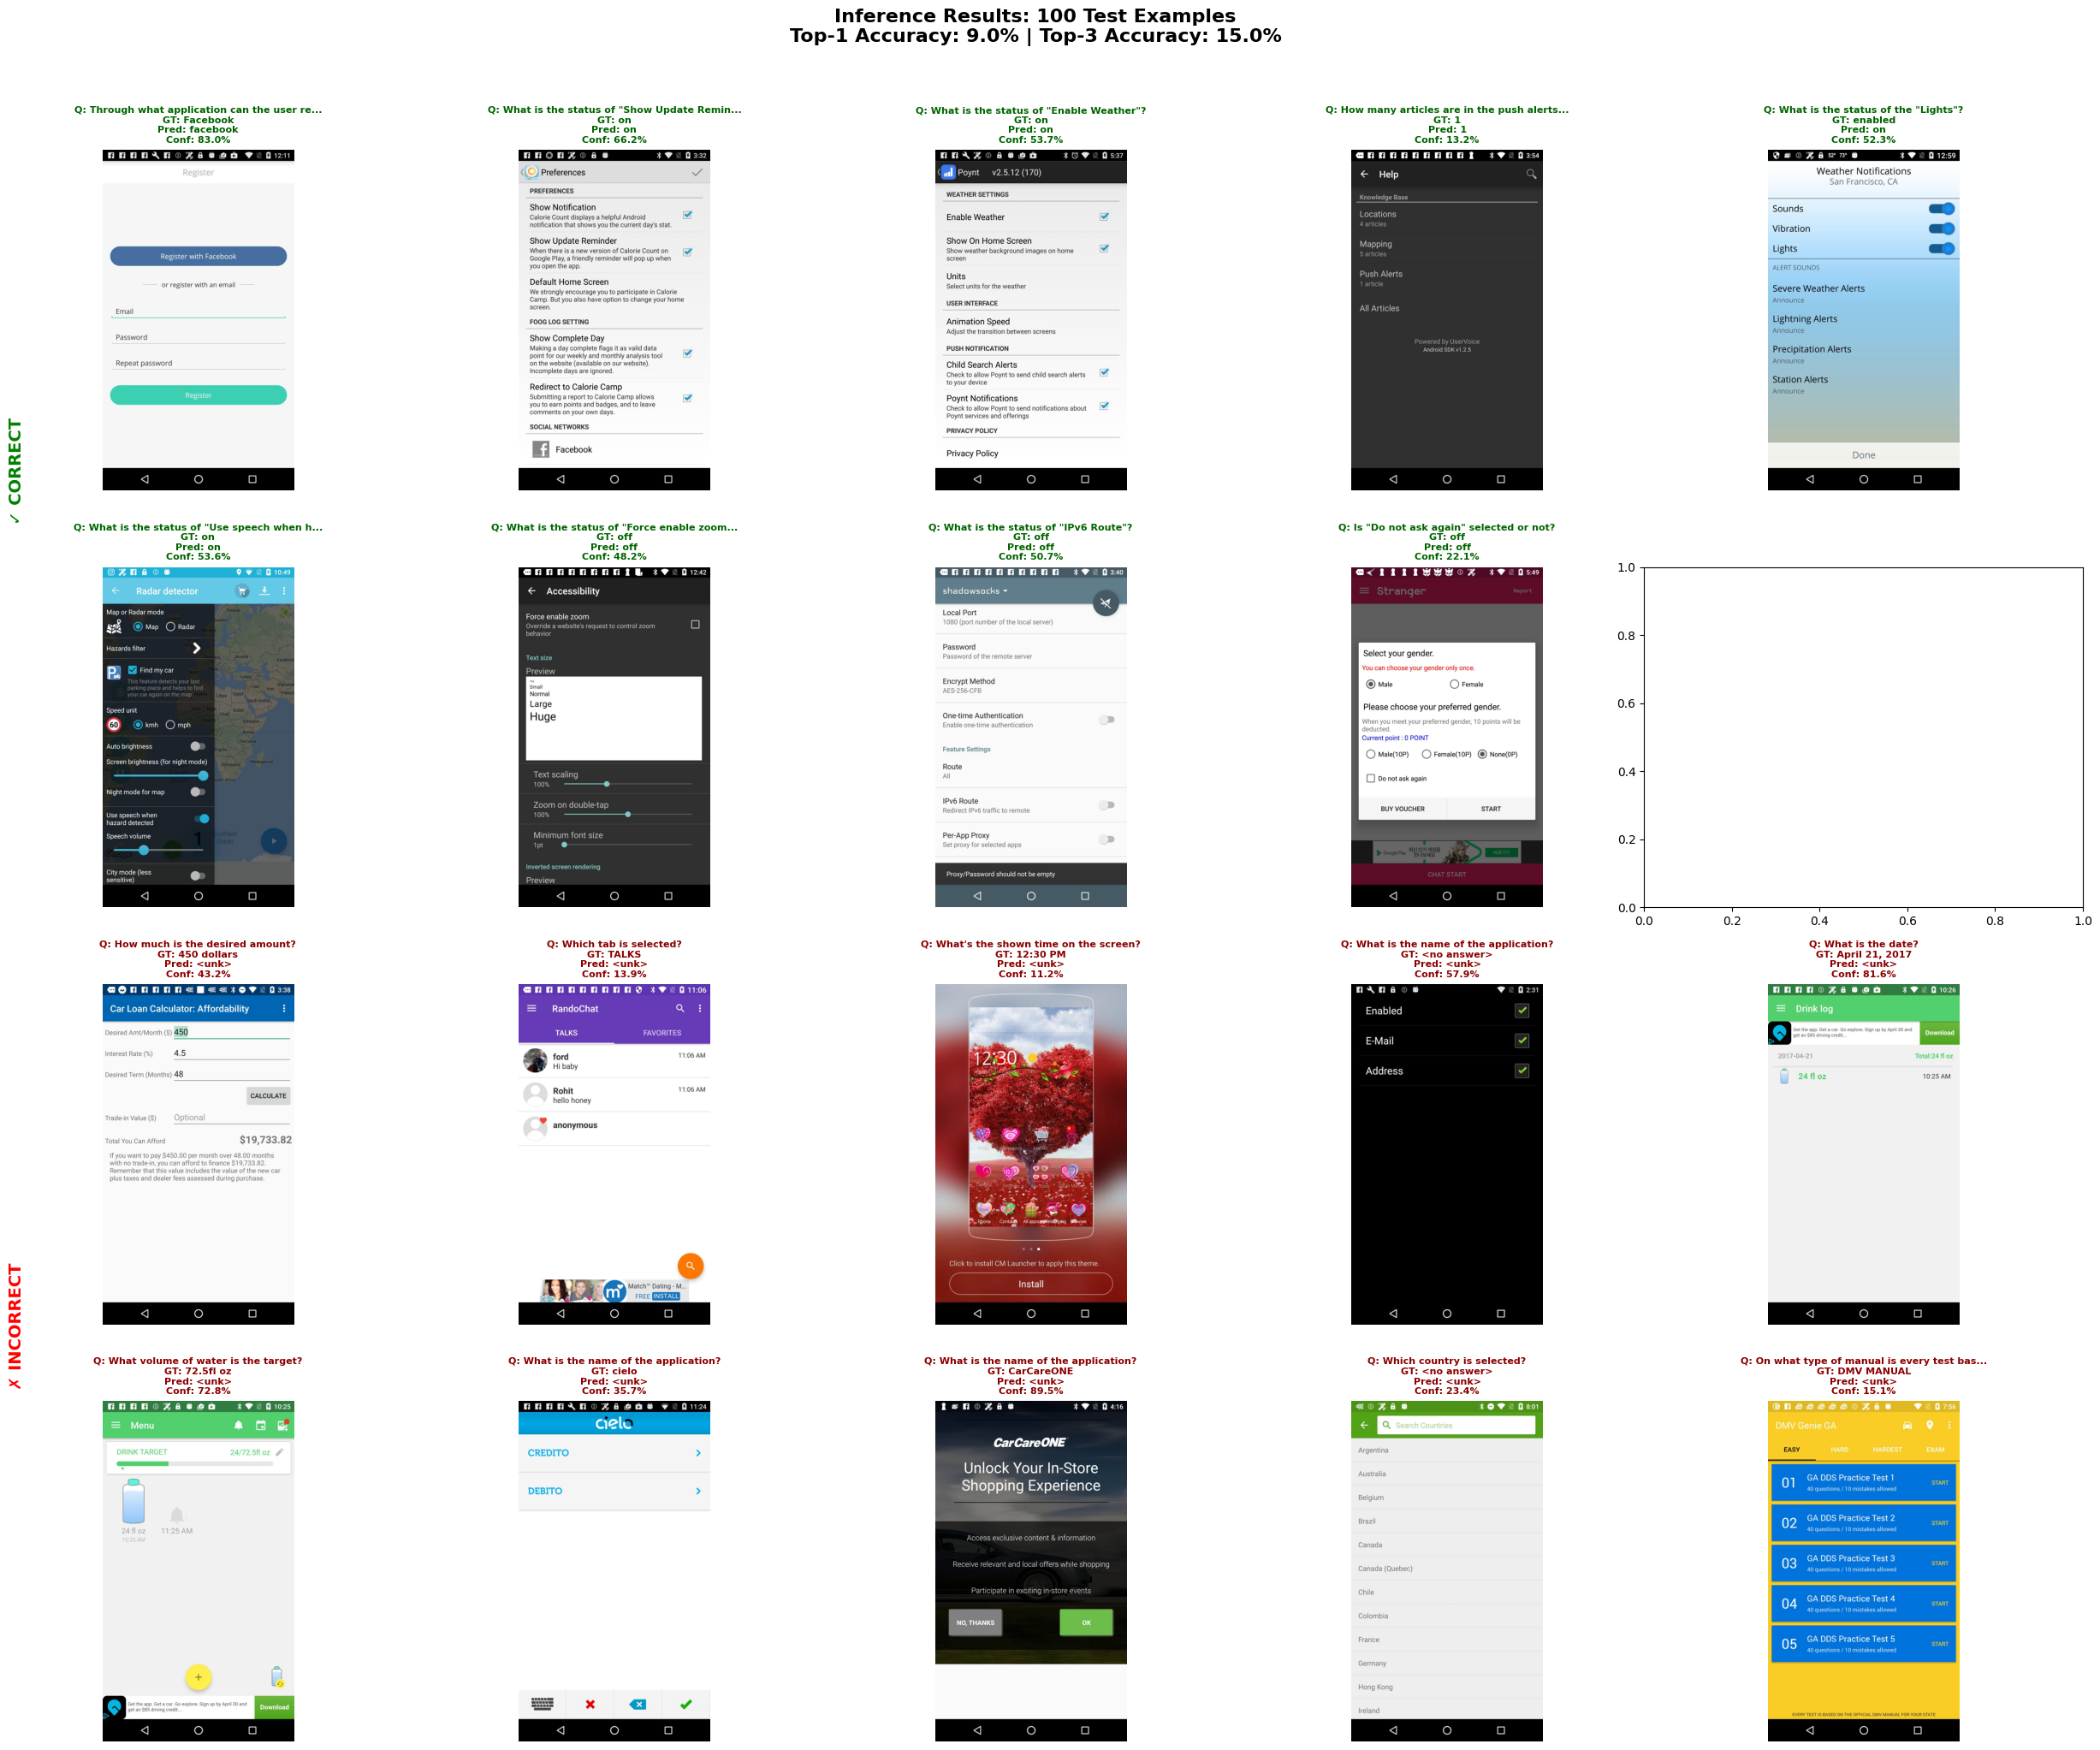

Saved: /content/examples_grid.png


In [34]:
#@title Block 9: Comprehensive Inference on 100 Test Examples
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter, defaultdict
import pandas as pd

# Load best weights if available
if os.path.exists('/content/best_model_weights.weights.h5'):
    print("Loading best model weights...")
    model.load_weights('/content/best_model_weights.weights.h5')
    print("Best weights loaded")
else:
    print("Using current model weights (best weights not found)")


# Enhanced Inference Function
def predict_answer(image, question, top_k=5):
    """
    Predict answer for a single image-question pair.

    Args:
        image: PIL Image or numpy array
        question: Question string
        top_k: Number of top predictions to return

    Returns:
        dict with predictions and confidence scores
    """
    # Preprocess image
    if hasattr(image, 'convert'):  # PIL Image
        img_tensor = preprocess_image(image)
    else:
        img_tensor = image
    img_tensor = tf.expand_dims(img_tensor, 0)

    # Preprocess question
    input_word_ids, input_mask, input_type_ids = preprocess_question(question)
    input_word_ids = tf.expand_dims(input_word_ids, 0)
    input_mask = tf.expand_dims(input_mask, 0)
    input_type_ids = tf.expand_dims(input_type_ids, 0)

    # Create input dict
    inputs = {
        'image': img_tensor,
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    # Get prediction
    logits = model(inputs, training=False)
    probabilities = tf.nn.softmax(logits, axis=-1)[0]

    # Get top-k predictions
    top_k_values, top_k_indices = tf.math.top_k(probabilities, k=min(top_k, NUM_ANSWERS))

    predictions = []
    for i in range(min(top_k, NUM_ANSWERS)):
        idx = top_k_indices[i].numpy()
        prob = top_k_values[i].numpy()
        answer = decode_answer(idx)
        predictions.append({
            'answer': answer,
            'confidence': float(prob),
            'index': int(idx)
        })

    return {
        'top_prediction': predictions[0]['answer'],
        'top_confidence': predictions[0]['confidence'],
        'top_k_predictions': predictions
    }

def check_correctness(predicted, ground_truth_list):
    """Check if prediction matches any ground truth answer."""
    pred_lower = predicted.lower().strip()
    for gt in ground_truth_list:
        if pred_lower == gt.lower().strip():
            return True
    return False

def check_top_k_correctness(predictions, ground_truth_list, k):
    """Check if any of top-k predictions match ground truth."""
    for pred in predictions[:k]:
        if check_correctness(pred['answer'], ground_truth_list):
            return True
    return False

def classify_question_type(question):
    """Classify question into categories for analysis."""
    question_lower = question.lower()

    if any(word in question_lower for word in ['what color', 'what is the color', 'which color']):
        return 'Color'
    elif any(word in question_lower for word in ['how many', 'number of', 'count']):
        return 'Counting'
    elif any(word in question_lower for word in ['where is', 'location of', 'position']):
        return 'Location'
    elif any(word in question_lower for word in ['what time', 'when', 'date', 'day']):
        return 'Time/Date'
    elif any(word in question_lower for word in ['what is the name', 'what is the title', 'name of']):
        return 'Name/Title'
    elif any(word in question_lower for word in ['what is the text', 'what does it say', 'written']):
        return 'Text Reading'
    elif any(word in question_lower for word in ['is there', 'are there', 'does it have']):
        return 'Yes/No'
    elif any(word in question_lower for word in ['what type', 'what kind', 'which type']):
        return 'Type/Category'
    else:
        return 'Other'

# Run Inference on 100 Test Examples
NUM_TEST_EXAMPLES = 100

# Select diverse examples (spread across the dataset)
np.random.seed(42)
if len(test_dataset) >= NUM_TEST_EXAMPLES:
    test_indices = np.random.choice(len(test_dataset), NUM_TEST_EXAMPLES, replace=False)
else:
    test_indices = np.arange(len(test_dataset))
    NUM_TEST_EXAMPLES = len(test_dataset)

results = []

# Run inference with progress bar
for i, idx in enumerate(tqdm(test_indices, desc="Running inference",
                             bar_format='{l_bar}{bar:40}{r_bar}')):
    sample = test_dataset[int(idx)]

    # Get prediction
    pred_result = predict_answer(sample['image'], sample['question'], top_k=5)

    # Classify question type
    q_type = classify_question_type(sample['question'])

    # Check correctness at different k values
    is_correct_top1 = check_correctness(pred_result['top_prediction'], sample['ground_truth'])
    is_correct_top3 = check_top_k_correctness(pred_result['top_k_predictions'], sample['ground_truth'], 3)
    is_correct_top5 = check_top_k_correctness(pred_result['top_k_predictions'], sample['ground_truth'], 5)

    # Store result
    results.append({
        'index': int(idx),
        'question': sample['question'],
        'question_type': q_type,
        'ground_truth': sample['ground_truth'],
        'predicted': pred_result['top_prediction'],
        'confidence': pred_result['top_confidence'],
        'top_5': pred_result['top_k_predictions'],
        'correct_top1': is_correct_top1,
        'correct_top3': is_correct_top3,
        'correct_top5': is_correct_top5,
        'image': sample['image']  # Store for visualization
    })

print(f"Completed inference on {NUM_TEST_EXAMPLES} examples")
#Calculate Comprehensive Metrics

# Overall accuracy metrics
top1_correct = sum(1 for r in results if r['correct_top1'])
top3_correct = sum(1 for r in results if r['correct_top3'])
top5_correct = sum(1 for r in results if r['correct_top5'])

top1_accuracy = top1_correct / NUM_TEST_EXAMPLES * 100
top3_accuracy = top3_correct / NUM_TEST_EXAMPLES * 100
top5_accuracy = top5_correct / NUM_TEST_EXAMPLES * 100

print(f"\n Overall Accuracy:")
print(f"Top-1 Accuracy: {top1_accuracy:6.2f}% ({top1_correct}/{NUM_TEST_EXAMPLES}) │")
print(f"Top-3 Accuracy: {top3_accuracy:6.2f}% ({top3_correct}/{NUM_TEST_EXAMPLES}) │")
print(f"Top-5 Accuracy: {top5_accuracy:6.2f}% ({top5_correct}/{NUM_TEST_EXAMPLES}) │")


#Visualizations

# Create comprehensive visualization figure
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# --- Plot 1: Accuracy Bar Chart ---
ax1 = fig.add_subplot(gs[0, 0])
accuracies = [top1_accuracy, top3_accuracy, top5_accuracy]
bars = ax1.bar(['Top-1', 'Top-3', 'Top-5'], accuracies, color=['#3498db', '#2ecc71', '#9b59b6'])
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Overall Accuracy (Top-K)', fontweight='bold')
ax1.set_ylim(0, 100)
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# --- Plot 2: Accuracy by Question Type ---
ax2 = fig.add_subplot(gs[0, 1])
q_types = list(question_type_stats.keys())
q_type_accs = [question_type_stats[qt]['correct_top1'] / question_type_stats[qt]['total'] * 100
               for qt in q_types]
q_type_counts = [question_type_stats[qt]['total'] for qt in q_types]

# Sort by count
sorted_indices = np.argsort(q_type_counts)[::-1]
q_types_sorted = [q_types[i] for i in sorted_indices]
q_type_accs_sorted = [q_type_accs[i] for i in sorted_indices]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(q_types_sorted)))
bars2 = ax2.barh(q_types_sorted, q_type_accs_sorted, color=colors)
ax2.set_xlabel('Top-1 Accuracy (%)')
ax2.set_title('Accuracy by Question Type', fontweight='bold')
ax2.set_xlim(0, 100)
for bar, acc in zip(bars2, q_type_accs_sorted):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{acc:.1f}%', va='center', fontsize=9)
ax2.grid(axis='x', alpha=0.3)

# --- Plot 3: Confidence Distribution ---
ax3 = fig.add_subplot(gs[0, 2])
all_confidences = [r['confidence'] * 100 for r in results]
ax3.hist(all_confidences, bins=20, color='#3498db', edgecolor='white', alpha=0.7)
ax3.axvline(np.mean(all_confidences), color='red', linestyle='--',
            label=f'Mean: {np.mean(all_confidences):.1f}%')
ax3.set_xlabel('Confidence (%)')
ax3.set_ylabel('Count')
ax3.set_title('Confidence Distribution', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# --- Plot 4: Confidence vs Correctness ---
ax4 = fig.add_subplot(gs[1, 0])
if correct_confidences and incorrect_confidences:
    ax4.hist([np.array(correct_confidences)*100, np.array(incorrect_confidences)*100],
             bins=15, label=['Correct', 'Incorrect'], color=['#2ecc71', '#e74c3c'],
             edgecolor='white', alpha=0.7)
    ax4.set_xlabel('Confidence (%)')
    ax4.set_ylabel('Count')
    ax4.set_title('Confidence: Correct vs Incorrect', fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

# --- Plot 5: Question Type Distribution (Pie Chart) ---
ax5 = fig.add_subplot(gs[1, 1])
q_type_counts_sorted = [q_type_counts[i] for i in sorted_indices]
wedges, texts, autotexts = ax5.pie(q_type_counts_sorted, labels=q_types_sorted,
                                    autopct='%1.1f%%', colors=colors,
                                    pctdistance=0.75)
ax5.set_title('Question Type Distribution', fontweight='bold')

# --- Plot 6: Top Predicted Answers ---
ax6 = fig.add_subplot(gs[1, 2])
predicted_answers = [r['predicted'] for r in results]
answer_counts = Counter(predicted_answers).most_common(10)
answers, counts = zip(*answer_counts) if answer_counts else ([], [])
y_pos = np.arange(len(answers))
ax6.barh(y_pos, counts, color='#9b59b6', edgecolor='white')
ax6.set_yticks(y_pos)
ax6.set_yticklabels([a[:20] + '...' if len(a) > 20 else a for a in answers], fontsize=9)
ax6.set_xlabel('Count')
ax6.set_title('Top 10 Predicted Answers', fontweight='bold')
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)

# --- Plot 7-9: Sample Predictions (Correct and Incorrect) ---
# Get correct and incorrect examples
correct_examples = [r for r in results if r['correct_top1']]
incorrect_examples = [r for r in results if not r['correct_top1']]

# Show 3 correct examples
ax_correct = fig.add_subplot(gs[2, 0])
ax_correct.set_title('Correct Predictions (Samples)', fontweight='bold', color='green')
ax_correct.axis('off')

# Create mini grid for correct examples
if correct_examples:
    for i, example in enumerate(correct_examples[:3]):
        ax_sub = fig.add_axes([0.05 + i*0.1, 0.02, 0.09, 0.12])
        ax_sub.imshow(example['image'])
        ax_sub.set_title(f"Q: {example['question'][:15]}...\nA: {example['predicted'][:12]}",
                        fontsize=6, color='green')
        ax_sub.axis('off')

# Show 3 incorrect examples
ax_incorrect = fig.add_subplot(gs[2, 1])
ax_incorrect.set_title('Incorrect Predictions (Samples)', fontweight='bold', color='red')
ax_incorrect.axis('off')

# Show mixed examples
ax_mixed = fig.add_subplot(gs[2, 2])
ax_mixed.set_title('Sample Predictions Overview', fontweight='bold')
ax_mixed.axis('off')

plt.savefig('/content/comprehensive_analysis.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print("Saved: /content/comprehensive_analysis.png")

# Detailed Visual Examples Grid
# Create grid showing 20 examples (10 correct, 10 incorrect)
fig2, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.flatten()

# Select examples
num_correct_show = min(10, len(correct_examples))
num_incorrect_show = min(10, len(incorrect_examples))

np.random.seed(123)
if correct_examples:
    correct_sample = np.random.choice(len(correct_examples), num_correct_show, replace=False)
    correct_to_show = [correct_examples[i] for i in correct_sample]
else:
    correct_to_show = []

if incorrect_examples:
    incorrect_sample = np.random.choice(len(incorrect_examples), num_incorrect_show, replace=False)
    incorrect_to_show = [incorrect_examples[i] for i in incorrect_sample]
else:
    incorrect_to_show = []

# Show correct examples (first 2 rows)
for i, example in enumerate(correct_to_show):
    ax = axes[i]
    ax.imshow(example['image'])

    q_short = example['question'][:40] + '...' if len(example['question']) > 40 else example['question']
    gt_short = example['ground_truth'][0][:25] if example['ground_truth'] else 'N/A'
    pred_short = example['predicted'][:25]

    title = f"Q: {q_short}\nGT: {gt_short}\nPred: {pred_short}\nConf: {example['confidence']*100:.1f}%"
    ax.set_title(title, fontsize=8, color='darkgreen', fontweight='bold')
    ax.axis('off')

    # Add green border
    for spine in ax.spines.values():
        spine.set_edgecolor('green')
        spine.set_linewidth(3)

# Show incorrect examples (last 2 rows)
for i, example in enumerate(incorrect_to_show):
    ax = axes[i + 10]
    ax.imshow(example['image'])

    q_short = example['question'][:40] + '...' if len(example['question']) > 40 else example['question']
    gt_short = example['ground_truth'][0][:25] if example['ground_truth'] else 'N/A'
    pred_short = example['predicted'][:25]

    title = f"Q: {q_short}\nGT: {gt_short}\nPred: {pred_short}\nConf: {example['confidence']*100:.1f}%"
    ax.set_title(title, fontsize=8, color='darkred', fontweight='bold')
    ax.axis('off')

    # Add red border
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(3)

# Add row labels
fig2.text(0.02, 0.75, '✓ CORRECT', fontsize=14, fontweight='bold', color='green',
          rotation=90, va='center')
fig2.text(0.02, 0.25, '✗ INCORRECT', fontsize=14, fontweight='bold', color='red',
          rotation=90, va='center')

plt.suptitle(f'Inference Results: {NUM_TEST_EXAMPLES} Test Examples\n'
             f'Top-1 Accuracy: {top1_accuracy:.1f}% | Top-3 Accuracy: {top3_accuracy:.1f}%',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/content/examples_grid.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print("Saved: /content/examples_grid.png")

# Detailed Results Table
# Create DataFrame for analysis
results_df = pd.DataFrame([{
    'Index': r['index'],
    'Question': r['question'][:50] + '...' if len(r['question']) > 50 else r['question'],
    'Question_Type': r['question_type'],
    'Ground_Truth': r['ground_truth'][0][:30] if r['ground_truth'] else 'N/A',
    'Predicted': r['predicted'][:30],
    'Confidence': f"{r['confidence']*100:.1f}%",
    'Correct': '✓' if r['correct_top1'] else '✗'
} for r in results])